# Импорт библиотек

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# Подготовка данных

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 64
num_epochs = 15

transform = v2.Compose([
    v2.Resize((100, 100)),  # Все изображения 100x100
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


full_dataset = ImageFolder(root='datasets/fruits-360/dataset/train', transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

test_dataset = ImageFolder(root='datasets/fruits-360/dataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Модель

In [7]:
class FruitCNN(nn.Module):
    def __init__(self, num_classes):
        super(FruitCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 6 * 6, 1024)  # Размер после пулингов: 100->50->25->12->6
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))  # -> [batch, 32, 50, 50]
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))  # -> [batch, 64, 25, 25]
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))  # -> [batch, 128, 12, 12]
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))  # -> [batch, 256, 6, 6]
        
        x = x.view(-1, 256 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Обучение

In [15]:
num_classes = len(full_dataset.classes)
model = FruitCNN(num_classes).to(device)
lr = 0.001

save_path = 'models/ERS-Fruits-360.pth'

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

counter = 0
patience = 5
best_val_loss = float('inf')

all_train_loss = []
all_val_loss = []
all_val_acc = []

num_epochs = 7
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc=f'Epoch: {epoch} | Train loader проход по батчам'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        y_pred = model(images)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f'Epoch: {epoch} | Val loader проход по батчам'):
            images, labels = images.to(device), labels.to(device)
            y_pred = model(images)
            loss = criterion(y_pred, labels)
            _, predicted = torch.max(y_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    
    scheduler.step(val_loss)

    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_val_acc.append(val_acc)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0

        state = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'accuracy': val_acc
        }
        torch.save(state, save_path)
        print(f"--> Модель сохранена на эпохе {epoch}.")
    else:
        counter += 1
        if counter >= patience:
            print(f"--> Early stopping на эпохе {epoch}")
            break

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch}/{num_epochs} | Train Loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.2f}% | lr: {current_lr}")

Epoch: 1 | Train loader проход по батчам: 100%|████████████████████████████████████| 1300/1300 [02:15<00:00,  9.57it/s]
Epoch: 1 | Val loader проход по батчам: 100%|████████████████████████████████████████| 325/325 [00:29<00:00, 11.20it/s]


--> Модель сохранена на эпохе 1.
Epoch 1/7 | Train Loss: 1.2193 | Val loss: 0.1339 | Val accuracy: 95.38% | lr: 0.001


Epoch: 2 | Train loader проход по батчам: 100%|████████████████████████████████████| 1300/1300 [02:11<00:00,  9.90it/s]
Epoch: 2 | Val loader проход по батчам: 100%|████████████████████████████████████████| 325/325 [00:28<00:00, 11.30it/s]


--> Модель сохранена на эпохе 2.
Epoch 2/7 | Train Loss: 0.3727 | Val loss: 0.0471 | Val accuracy: 98.59% | lr: 0.001


Epoch: 3 | Train loader проход по батчам: 100%|████████████████████████████████████| 1300/1300 [02:05<00:00, 10.33it/s]
Epoch: 3 | Val loader проход по батчам: 100%|████████████████████████████████████████| 325/325 [00:28<00:00, 11.29it/s]


--> Модель сохранена на эпохе 3.
Epoch 3/7 | Train Loss: 0.2453 | Val loss: 0.0157 | Val accuracy: 99.48% | lr: 0.001


Epoch: 4 | Train loader проход по батчам:   3%|█                                     | 36/1300 [00:03<02:16,  9.29it/s]


KeyboardInterrupt: 

# Тестовый запрос

C:\Users\Михаил\AppData\Local\Temp\ipykernel_24544\2980025291.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("_models/ERS-Fruits-360.pth", map_l

Истинный класс: Apple worm 1 (ID: 29)
Предсказанный класс: Apple worm 1 (ID: 29)


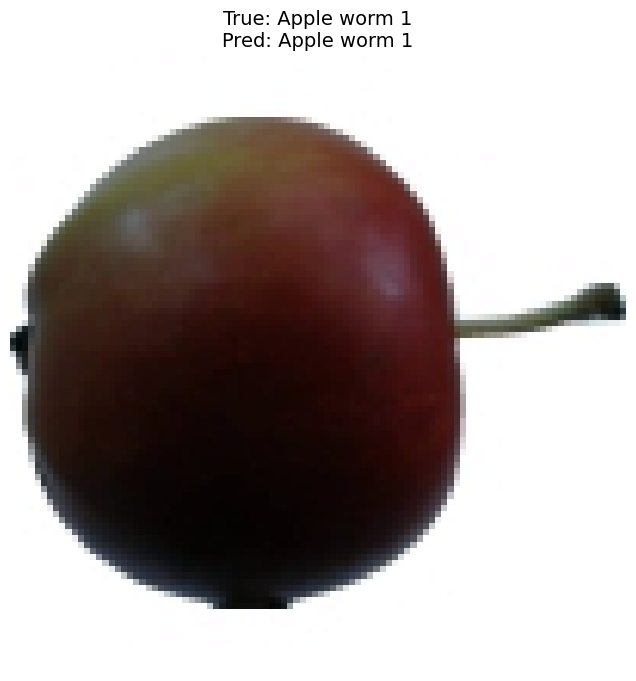

In [17]:
import matplotlib.pyplot as plt
import numpy as np

num_classes = len(full_dataset.classes)

checkpoint = torch.load("_models/ERS-Fruits-360.pth", map_location=device)
model = FruitCNN(num_classes).to(device)
model.load_state_dict(checkpoint["model_state_dict"])

def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

image, true_label = test_dataset[5205]
original_image = denormalize(image.clone())

input_tensor = image.unsqueeze(0).to(device)

# Предсказание модели
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    _, predicted_idx = torch.max(output, 1)
    predicted_label = predicted_idx.item()

np_image = original_image.numpy().transpose((1, 2, 0))
np_image = np.clip(np_image, 0, 1)

# Получаем названия классов
true_class = test_dataset.classes[true_label]
predicted_class = test_dataset.classes[predicted_label]

print(f"Истинный класс: {true_class} (ID: {true_label})")
print(f"Предсказанный класс: {predicted_class} (ID: {predicted_label})")

plt.figure(figsize=(8, 8))
plt.imshow(np_image)

plt.title(f'True: {true_class}\nPred: {predicted_class}', fontsize=14)
plt.axis('off')
plt.gca().set_frame_on(True)
plt.gca().patch.set_edgecolor(edge_color)
plt.gca().patch.set_linewidth(6)
plt.show()